## https://pymoo.org/getting_started.html

In [1]:
!pip install pymoo==0.4.2.2

## Questions:

- What are reference directions / how do they work? https://pymoo.org/misc/reference_directions.html



In [2]:
import numpy as np
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:,0]**2 + x[:,1]**2
        f2 = (x[:,0]-1)**2 + x[:,1]**2

        g1 = 2*(x[:, 0]-0.1) * (x[:, 0]-0.9) / 0.18
        g2 = - 20*(x[:, 0]-0.4) * (x[:, 0]-0.6) / 4.8

        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1, g2])


    # --------------------------------------------------
    # Pareto-front - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_front(self, flatten=True, **kwargs):
        f1_a = np.linspace(0.1**2, 0.4**2, 100)
        f2_a = (np.sqrt(f1_a) - 1)**2

        f1_b = np.linspace(0.6**2, 0.9**2, 100)
        f2_b = (np.sqrt(f1_b) - 1)**2

        a, b = np.column_stack([f1_a, f2_a]), np.column_stack([f1_b, f2_b])
        return stack(a, b, flatten=flatten)

    # --------------------------------------------------
    # Pareto-set - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_set(self, flatten=True, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)

problem = MyProblem()

In [3]:
from pymoo.factory import get_problem

zdt1 = get_problem("zdt1")

In [4]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)


In [5]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 40)

In [6]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=True)


n_gen |  n_eval |   cv (min)   |   cv (avg)   |     igd      |      gd      |      hv     
    1 |      40 |  0.00000E+00 |  2.36399E+01 |  0.355456661 |  0.005362269 |  0.259340233
    2 |      50 |  0.00000E+00 |  1.15486E+01 |  0.355456661 |  0.005362269 |  0.259340233
    3 |      60 |  0.00000E+00 |  5.277918607 |  0.355456661 |  0.005362269 |  0.259340233
    4 |      70 |  0.00000E+00 |  2.406068542 |  0.336177786 |  0.003791374 |  0.267747228
    5 |      80 |  0.00000E+00 |  0.908316880 |  0.146187673 |  0.030825699 |  0.326821728
    6 |      90 |  0.00000E+00 |  0.264746300 |  0.146187673 |  0.030825699 |  0.326821728
    7 |     100 |  0.00000E+00 |  0.054063822 |  0.127166639 |  0.048434536 |  0.326821728
    8 |     110 |  0.00000E+00 |  0.003060876 |  0.116635438 |  0.040756917 |  0.333328216
    9 |     120 |  0.00000E+00 |  0.00000E+00 |  0.114104403 |  0.033780540 |  0.333467251
   10 |     130 |  0.00000E+00 |  0.00000E+00 |  0.113905849 |  0.079757906 |  0.336916611

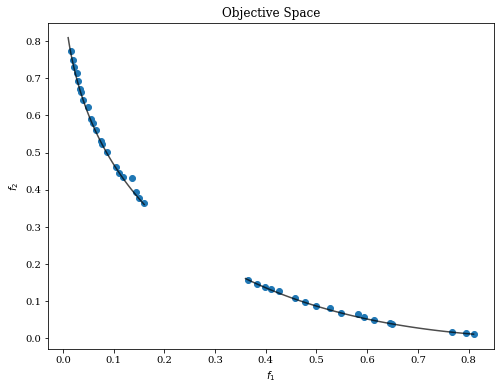

In [7]:
from pymoo.visualization.scatter import Scatter

# get the pareto-set and pareto-front for plotting
ps = problem.pareto_set(use_cache=False, flatten=False)
pf = problem.pareto_front(use_cache=False, flatten=False)

# Design Space
plot = Scatter(title = "Design Space", axis_labels="x")
plot.add(res.X, s=30, facecolors='none', edgecolors='r')
plot.add(ps, plot_type="line", color="black", alpha=0.7)
plot.do()
plot.apply(lambda ax: ax.set_xlim(-0.5, 1.5))
plot.apply(lambda ax: ax.set_ylim(-2, 2))
plot.show()

# Objective Space
plot = Scatter(title = "Objective Space")
plot.add(res.F)
plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()

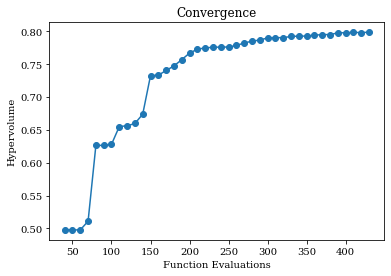

In [8]:
import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([1.0, 1.0]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o')
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()